In [1]:
import numpy as np, pandas as pd, glob, os, scipy.stats as ss
from matplotlib import pyplot as plt
%matplotlib inline

def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [2]:
plt.style.use(['tableau-colorblind10'])

In [3]:
import seaborn as sns
sns.set(font_scale=1)
## Set tick style
sns.set(style="ticks", context="talk")

In [4]:
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
geno_df = pd.read_csv(geno_path)
strain_ix = geno_df.columns.tolist().index('Block') + 1
geno_strains = np.array(geno_df.columns.tolist()[strain_ix:])

In [5]:
chrlist = geno_df.Chrom.unique()
## Gather the length of each chromosome
clens = [geno_df[(geno_df.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [6]:
file_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan_qtlruns_Jan162019_curated_baselined_median51.csv.gz'
df = pd.read_csv(file_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
df.index = df.strain
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))

In [7]:
len(geno_strains)

104

In [8]:
segs = sorted(geno_strains)

In [9]:
t = 37
d = 0.125
tempdf = df[(df.temp==t) & (df.amphB==d)]
tempdf.index = tempdf.strain
cum_auc = tempdf[times_ixs].cumsum(axis=1)*dx
med_auc = cum_auc.groupby(cum_auc.index).agg(np.median,axis=0).T[geno_strains].T

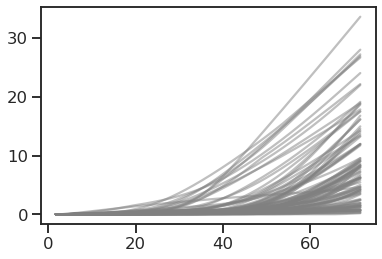

In [10]:
plt.plot(timex,med_auc.T[geno_strains].T[times_ixs].T.values,color='grey',alpha=0.5);

In [11]:
phenos = pd.read_csv('/home/croth/Desktop/Cdx_phenotypes.csv.gz',index_col=0)

In [12]:
def function_qtl(geno,pheno,dr=1,de=2):
    
    betadf = pd.DataFrame(
                [np.ones(len(geno)),geno.values],
                    columns=geno.index,
                index=['b0','b1']).T
    
    res = np.linalg.lstsq(betadf.values, pheno.values,rcond=-1)
    coeff = res[0]
    yhat = coeff[0] + np.outer(betadf['b1'].values,coeff[1])
    
    sse = np.sum((pheno.values-yhat)**2,axis=0)
    ssy = np.sum((pheno - pheno.mean())**2,axis=0).values
    rsq = (ssy - sse)/ssy
    
    mse = sse/(len(geno)-2)
    msr = (ssy-sse)/1
    fratio = msr/mse
    logP = -np.log10(ss.f.sf(fratio, dr, len(geno)-de))
    
    return (rsq,logP)

In [13]:
median_od = tempdf.groupby(tempdf.index)[times_ixs].median()

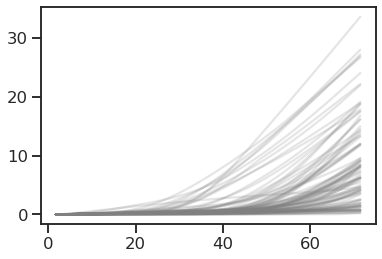

In [14]:
plt.plot(timex,med_auc.T.values,alpha=0.2,color='grey');

fig,ax = plt.subplots(1,1,figsize=(5,3));

time_cor = []
time_pval = []
for i,j in enumerate(times_ixs):
    #k = phenos['Capsule_diameter_residual'].T[segs].values
    k = phenos['Melanin'].T[segs].values
    l = med_auc[j].T[segs].values
    z = ss.spearmanr(k,l)
    time_cor.append(z.correlation)
    time_pval.append(z.pvalue)
plt.plot(timex,time_cor,color='k',alpha=0.5);
print(np.max(time_cor))
    
time_cor = []
time_pval = []
for i,j in enumerate(times_ixs):
    k = phenos['Capsule_diameter_residual'].T[segs].values
    #k = phenos['Melanin'].T[segs].values
    l = med_auc[j].T[segs].values
    z = ss.spearmanr(k,l)
    time_cor.append(z.correlation)
    time_pval.append(z.pvalue)
plt.plot(timex,time_cor,color='b',alpha=0.5);

In [15]:
#phenos[['Melanin','39_0.0']].corr()

In [16]:
gv = geno_df[geno_strains].drop_duplicates()

test = gv.apply(function_qtl,
                args=[median_od.T[geno_strains].T],axis=1)

In [17]:
test.shape

(2777,)

In [18]:
testr = pd.DataFrame([r[0] for i,r in test.iteritems()],index=test.index,columns=med_auc.columns)
testr = pd.concat([gv,testr],axis=1)
testr.shape

(2777, 384)

In [19]:
testp = pd.DataFrame([r[1] for i,r in test.iteritems()],index=test.index,columns=med_auc.columns)
testp = pd.concat([gv,testp],axis=1)
testp.shape

(2777, 384)

In [20]:
geno_dfp = geno_df.merge(testp)

In [21]:
geno_dfp['Max'] = geno_dfp[times_ixs].T.max()
geno_dfp['Ave'] = geno_dfp[times_ixs].T.mean()
geno_dfp['Last'] = geno_dfp[times_ixs[-1]]

In [22]:
t,d

(37, 0.125)

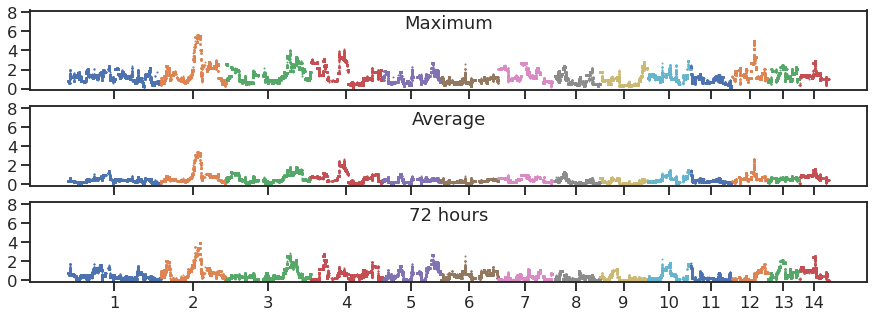

In [23]:
fig,ax = plt.subplots(3,1,figsize=(15,5),sharey=True,sharex=True)

plt.sca(ax[0])
for i,c in enumerate(chrlist):
    plt.title('Maximum',y=.7)
    k = geno_dfp[(geno_dfp.Chrom==c)][['Pos','Max']]
    
    plt.plot(k.Pos.values+cumpos[i],k.Max.values,'.',ms=2);
    plt.ylim(-0.2,8.2)
    plt.yticks(np.arange(0,10,2))
plt.sca(ax[1])
for i,c in enumerate(chrlist):
    
    k = geno_dfp[(geno_dfp.Chrom==c)][['Pos','Ave']]
    
    plt.plot(k.Pos.values+cumpos[i],k.Ave.values,'.',ms=2);
    plt.ylim(-0.2,8.2)
    plt.yticks(np.arange(0,10,2));
    plt.title('Average',y=.7)
    
plt.sca(ax[2])    
for i,c in enumerate(chrlist):
    plt.title('72 hours',y=.7)
    k = geno_dfp[(geno_dfp.Chrom==c)][['Pos','Last']]
    
    plt.plot(k.Pos.values+cumpos[i],k.Last.values,'.',ms=2);
    plt.ylim(-0.2,8.2)
    plt.yticks(np.arange(0,10,2));
    
plt.xticks(chrom_midpts,np.arange(1,15));

In [24]:
geno_dfr = geno_df.merge(testr)

In [25]:
geno_dfr['Max'] = geno_dfr[times_ixs].T.max()
geno_dfr['Ave'] = geno_dfr[times_ixs].T.mean()

In [26]:
med_auc.shape

(104, 280)

In [27]:
ch12 = geno_dfp[(geno_dfp.Chrom=='Chr12')].copy();

In [28]:
ssk2 = pd.read_csv('../DATA/GENOTYPE/CNL05560.csv.gz',index_col=0)
ssk2.head()

,Start,End,Ref,Alt,Var,Strand,Seq,Gene
0,554526,554526,C,C,0.0,1,5,CNL05560
1,554527,554527,T,T,0.0,1,5,CNL05560
2,554528,554528,G,G,0.0,1,5,CNL05560
3,554529,554529,C,C,0.0,1,5,CNL05560
4,554530,554530,C,C,0.0,1,5,CNL05560


time_cor = []
time_sp = []
for c in med_auc.columns:
    
    tp = med_auc.T[segs].T[c].values
    h2o2 = phenos.T[segs].T['H2O2'].values
    
    sp = ss.spearmanr(tp,h2o2)
    
    time_sp.append(sp.correlation)
    time_cor.append(sp.pvalue)

plt.plot(timex, geno_dfp[(geno_dfp.Chrom=='Chr12')][times_ixs].max());

fig,ax = plt.subplots(1,2,figsize=(12,3))
plt.sca(ax[0])
plt.plot(timex,np.array(time_sp))
plt.sca(ax[1])
plt.plot(timex,-np.log10(np.array(time_cor)));

In [29]:
ch12_gv = ch12[segs].drop_duplicates().copy()

In [30]:
ch12_gv.shape

(126, 104)

In [31]:
phenos.T[segs].T[['H2O2']]

,H2O2
SS-A837,2
SS-B307,0.5
SS-B310,0
SS-B311,4
SS-B312,5
...,...
SS-C272,4
SS-C290,4
SS-C291,4
XL280a,4


In [32]:
h2o2_path = '../DATA/PHENOTYPE/H2O2/H2O2_data.csv'
phenos = pd.read_csv(h2o2_path,index_col=0)
phenos.head()

,H2O2,SSK1,SSK2,RIC8
SS-A837,2.00,1.0,1.0,1.0
SS-B307,0.75,0.0,0.0,1.0
SS-B310,0.00,1.0,0.0,1.0
SS-B311,4.00,0.0,1.0,1.0
SS-B312,5.00,0.0,1.0,0.0


In [33]:
h2o2 = ch12_gv.apply(association_logPval,
                    args=[phenos.loc[ch12_gv.columns,'H2O2'].values],axis=1)

In [34]:
ch12_gv['H2O2'] = h2o2#[a[1][0] for a in h202]

In [35]:
ch12_gv.tail()

,SS-A837,SS-B307,SS-B310,SS-B311,SS-B312,SS-B313,SS-B314,SS-B315,SS-B316,SS-B317,...,SS-C036,SS-C039,SS-C242,SS-C271,SS-C272,SS-C290,SS-C291,XL280a,XL280alpha,H2O2
84229,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.112810
84356,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.128454
84357,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.005019
84490,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.040313
84492,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.071636


In [36]:
ch12_h202 = ch12.merge(ch12_gv)

In [37]:
ch12_h202.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,252901s,253800s,254700s,255601s,256500s,257400s,Max,Ave,Last,H2O2
0,Chr12,6785,75592.1,1.0,C,T,1,7010,snp,29,...,0.154642,0.148820,0.140810,0.135108,0.132331,0.128365,1.269139,0.398147,0.128365,0.679702
1,Chr12,18480,66140.1,1.0,GGCGGCTAT,GC,1,6309,indel,44,...,0.154642,0.148820,0.140810,0.135108,0.132331,0.128365,1.269139,0.398147,0.128365,0.679702
2,Chr12,22988,76118.4,1.0,T,C,1,7313,snp,64,...,0.233371,0.226603,0.218229,0.211685,0.208150,0.203728,1.176393,0.362294,0.203728,0.799807
3,Chr12,23040,73236.9,1.0,C,T,1,7007,snp,65,...,0.233371,0.226603,0.218229,0.211685,0.208150,0.203728,1.176393,0.362294,0.203728,0.799807
4,Chr12,23049,66534.8,1.0,A,G,1,6473,snp,67,...,0.233371,0.226603,0.218229,0.211685,0.208150,0.203728,1.176393,0.362294,0.203728,0.799807


In [38]:
#phenos[['H2O2','37_0.125','Fludioxonil']].corr(method='spearman')

In [39]:
def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

In [40]:
ch12.T[ch12.Max.idxmax()]

Chrom          Chr12
Pos           556577
Qual          128879
Callrate           1
Ref                G
              ...   
256500s     0.727223
257400s     0.724735
Max          4.97673
Ave            2.664
Last        0.724735
Name: 82669, Length: 408, dtype: object

In [41]:
ch12 = ch12.sort_values('Pos')
ch12_h202 = ch12_h202.sort_values('Pos')

In [42]:
from matplotlib import rc
xl280al = 'XL280'+r'$\alpha$'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

In [43]:
(tempdf[times_ixs].sum(axis=1)*dx).groupby('strain').median()

strain
SS-A837        8.383125
SS-B307        2.394925
SS-B308        7.026650
SS-B310        0.653250
SS-B311       18.908500
                ...    
SS-C272        5.822625
SS-C290        1.456500
SS-C291        0.847625
XL280a        11.984250
XL280alpha    14.541025
Length: 119, dtype: float64

In [44]:
ch12_ix_peak = ch12.Max.idxmax()
#ch12data = phenos[['H2O2','37_0.125']].copy()
ch12data = phenos[['H2O2']].copy()
ch12data['37_0.125'] = (tempdf[times_ixs].sum(axis=1)*dx).groupby('strain').median()
ch12data['QTL12'] = geno_df.T[ch12_ix_peak][ch12data.index]
ch12data['Chromosome 12\nQTL allele'] = [xl280_label 
                            if a == 0 else _431_label for a in ch12data.QTL12]
ch12data['H2O2_Z'] = myminmax(ch12data['H2O2'].values)
ch12data['HTG_DRUG'] = myminmax(ch12data['37_0.125'].values)
ch12data.head()

,H2O2,37_0.125,QTL12,Chromosome 12\nQTL allele,H2O2_Z,HTG_DRUG
SS-A837,2.00,8.383125,1,431$\mathrm{\alpha}$,0.40,0.244912
SS-B307,0.75,2.394925,0,XL280$\bf{a}$,0.15,0.065452
SS-B310,0.00,0.653250,0,XL280$\bf{a}$,0.00,0.013256
SS-B311,4.00,18.908500,1,431$\mathrm{\alpha}$,0.80,0.560345
SS-B312,5.00,5.445800,1,431$\mathrm{\alpha}$,1.00,0.156883


In [45]:
spho = np.round(ch12data[['H2O2','37_0.125']
            ].corr(method='spearman').values[0][1],2)
spho

0.5

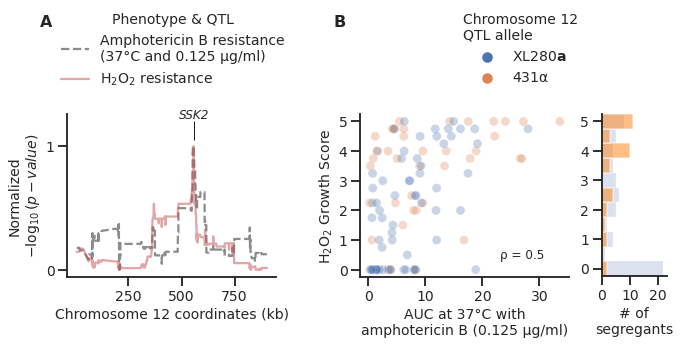

In [46]:
fig,ax = plt.subplots(1,2,figsize=(9,3))
plt.sca(ax[0])
plt.plot(ch12.Pos.values,myminmax(ch12.Max.values),'k--',
         alpha=0.5,ms=1,
         label=u'Amphotericin B resistance\n(37\u00B0C and 0.125 \u03BCg/ml)');
plt.plot(ch12_h202.Pos.values, 
         myminmax(ch12_h202['H2O2'].values),'r-',
         alpha=0.5,ms=1,label='H$_2$O$_2$ resistance')
plt.yticks([0,1],fontsize=14)

plt.vlines(np.mean([ssk2.Start.min(),ssk2.End.max()]), 
           1.05, 1.2,linewidth=1,color='k')
plt.text(s='SSK2',x=np.mean([ssk2.Start.min(),ssk2.End.max()]),
         y=1.2,ha='center',va='bottom',fontsize=12,style='italic')


k,l = plt.xticks()
plt.xticks(k[2:-1],np.array([int(a/1000) for a in k[2:-1]]),fontsize=14);
plt.xlabel('Chromosome 12 coordinates (kb)',fontsize=14)
plt.ylabel('Normalized\n$-\log_{10}\,(p-value)$',fontsize=14);

lg = plt.legend(title='Phenotype & QTL',
           bbox_to_anchor=(1.1,1.7),
           frameon=False,fontsize=14)
lg.get_title().set_fontsize(14)
plt.title('A',fontsize=16,fontweight='bold',x=-0.1,y=1.5)
[ax[0].spines[a].set_visible(False) for a in ['top','right']]



plt.sca(ax[1])
[ax[1].spines[a].set_visible(False) for a in ['top','right']]

sns.scatterplot(x='37_0.125',y='H2O2',
                data=ch12data,
                hue='Chromosome 12\nQTL allele',alpha=0.3,
                hue_order=[xl280_label,_431_label])

lg = plt.legend(title='Chromosome 12\nQTL allele',
           bbox_to_anchor=(1.1,1.7),
           frameon=False,fontsize=14)
lg.get_title().set_fontsize(14)

plt.xlabel('AUC at 37\u00B0C with\namphotericin B (0.125 \u03BCg/ml)',
           fontsize=14)
plt.ylabel('H$_2$O$_2$ Growth Score',fontsize=14)
plt.yticks(np.arange(6),fontsize=14)
plt.title('B',fontsize=16,fontweight='bold',x=-0.1,y=1.5)
plt.ylim(-0.25,5.25)
plt.xticks(fontsize=14)
plt.text(s='\u03C1 = %s'%spho,fontsize=12,
         x=27,y=0.5,va='center',ha='center')


sub2 = fig.add_axes([0.95,0.13,0.1,.75])
plt.hist(ch12data[(ch12data.QTL12==0)]['H2O2'].values,
        alpha=0.2,orientation='horizontal',
        bins=np.arange(-0.25,5.5,.5))


plt.hist(ch12data[(ch12data.QTL12==1)]['H2O2'].values,
         alpha=0.5,orientation='horizontal',
         bins=np.arange(-0.25,5.5,.5),
         color='tab:orange')
plt.yticks(np.arange(6),fontsize=14)
plt.xticks([0,10,20],fontsize=14)
plt.ylim(-0.25,5.25)
plt.xlabel('# of\nsegregants',fontsize=14)
[sub2.spines[a].set_visible(False) for a in ['top','right']]

plt.subplots_adjust(wspace=0.4);

plt.savefig('../FIGURES/SUPP/PDFs/S20_Fig.pdf',
            dpi=300,bbox_inches='tight');